# Ćwiczenie 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import functools
import time

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [5]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

## Dane 


In [7]:
import random
import math

def generate_random(qnt=100,m=-100,M=100):
    data = []
    for i in range(qnt):
        x = random.uniform(m,M)
        y = random.uniform(m,M)
        data.append((x,y))
    return data
        

def generate_circle(qnt,r,center):
    data= []
    for i in range(qnt):
        rd = math.pi * 2 * random.random()
        x = math.sin(rd) * r +center[0]
        y = math.cos(rd) * r + center[1]
        data.append((x,y))
    return data

def generate_rectangle(qnt=100,LL=(-10,-10),UR=(10,10)):
    data= []
    a  = (UR[0]-LL[0])
    b= (UR[1]-LL[1])
    l = 2*a + 2*b
    for i in range(qnt):
        p = random.uniform(0,l)
        if p <= a:
            x = p + LL[0]
            y = LL[1] 
        elif p <= 2*a:
            x= p -a +LL[0]
            y= UR[1] 
        elif p <= 2*a +b:
            x= LL[0] 
            y= p -2*a  + LL[1]
        else: 
            x = UR[0] 
            y= p-2*a-b +LL[1]
        data.append((x,y))
    return data
    
    
def generate_square(axis =20,diagonal=25,LL=(0,0),UR=(10,10)):
    data= []
    data.append(LL)
    data.append(UR)
    data.append((LL[0],UR[1]))
    data.append((UR[0],LL[1]))
    
    a  = (UR[0])

    
    for i in range(axis):
        p = random.uniform(0,a)
        x=p
        y=0
        data.append((x,y))
        
    for i in range(axis):
        p = random.uniform(0,a)
        x=0
        y=p
        data.append((x,y))  
    
    for i in range(diagonal):
        x = random.uniform(0,UR[0])
        data.append((x,x))
    for i in range(diagonal):
        x = random.uniform(LL[0],UR[0])
        data.append((x,-x + UR[1]))
    
    return data  




## wyznacznik


In [1]:
def det3x3(a,b,c,eps):
    d= ((a[0]*b[1] + a[1]*c[0]+ b[0]*c[1] - b[1]*c[0] - a[1]*b[0]-a[0]*c[1]))
    if d > eps: return 1
    elif d < -eps: return -1
    else: return 0


## Prezentacja danych

<IPython.core.display.Javascript object>


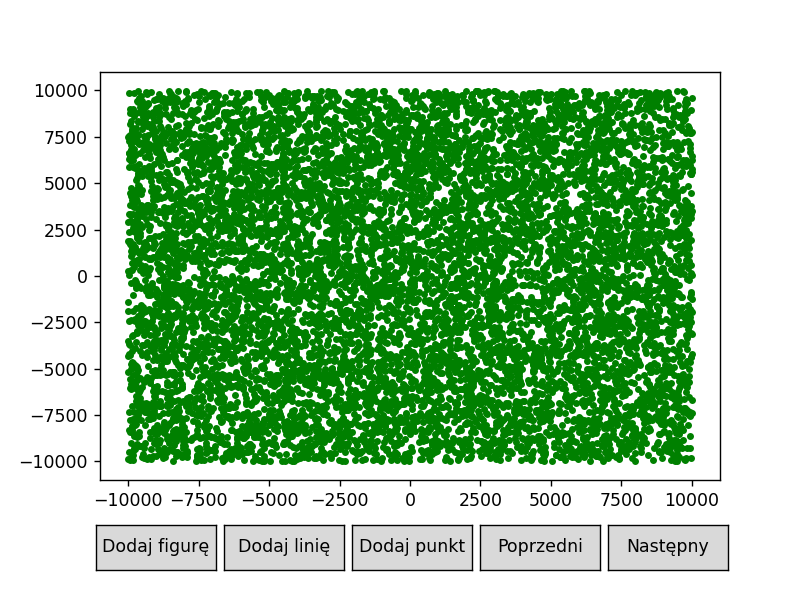

In [219]:
%matplotlib notebook
data1 = generate_random(qnt=10000,m=-10000,M=10000)
data2 = generate_circle(3000,1000,(0,0))
data3 = generate_rectangle(qnt=20000,LL=(-1000,-1000),UR=(1000,1000))
data4 = generate_square(axis =2500,diagonal=2500,LL=(0,0),UR=(1000,1000))
scenes=[Scene( [ PointsCollection(data1, color='green', marker = ".")]),  
        Scene([ PointsCollection(data2, color='red', marker=".")]),
        Scene([PointsCollection(data3, color='blue')]),
        Scene([PointsCollection(data4, color='orange',marker =".")]),]
             

plot=Plot(scenes = scenes)
plot.draw() 

In [9]:
def distance(a,b):
    return math.sqrt((b[0] - a[0])**2 + (b[1]-a[1])**2)

In [10]:
 def orient(a,b,c,eps):
    x= det3x3(a,b,c,eps)
    return -x



## Algorytm Grahama

In [5]:
def graham(data):
    eps=1e-8
    scenes=[]
    scenes.append(Scene( [ PointsCollection(data, color='green')]))
    data.sort(key =lambda item: (item[1],item[0]))
    p0 =data[0]
    data= data[1:]
    data = sorted(data, key=functools.cmp_to_key(lambda x,y: orient(p0,x,y,eps)))
    m = len(data)
    data_d=[]
    data_d.append(p0)
    data_d.append(data[0])
    
    for i in range (1,m):
        p=data_d.pop()
        d=det3x3(p0,p,data[i],eps)
        if d ==0:
            if distance(p0,p) > distance(p0,data[i]):
                data_d.append(p)
            else: data_d.append(data[i])
        else: 
            data_d.append(p)
            data_d.append(data[i])

    scenes.append(Scene( [ PointsCollection(data_d, color='green')]))

    s=[]
    s.append(p0)
    s.append(data_d[1])
    i=2

    while i < len(data_d): 
        pt=s.pop()
        pp=s.pop()
        pi=data_d[i]
        scenes.append(Scene([ PointsCollection(data_d, color='green' ),
                         PointsCollection([pt,pp,pi], color='red'),
                           PointsCollection(s[:], color='blue')]))
        if det3x3(pp,pt,pi,eps) > 0:
            s.append(pp)
            s.append(pt)
            s.append(pi)
            i+=1
        elif det3x3(pp,pt,pi,eps) ==0:
            s.append(pp)
            s.append(pi)
            i+=1
        else: s.append(pp)
    
    l=[]
    for i in range(0,len(s)-1):
        l.append([s[i],s[i+1]])
    l.append([s[0],s[len(s)-1]])
        
    scenes.append(Scene([ PointsCollection(data_d, color='green' ),
                           PointsCollection(s[:], color='blue')],
                       [LinesCollection(l[:])]))
    return scenes,s

In [4]:
def graham_time(data):
    eps=1e-8
    p0=min(data,key=lambda x: (x[1],x[0]))
    data= data[1:]
    data = sorted(data, key=functools.cmp_to_key(lambda x,y: orient(p0,x,y,eps)))
    m = len(data)
    data_d=[]
    data_d.append(p0)
    data_d.append(data[0])
    
    for i in range (1,m):
        p=data_d.pop()
        d=det3x3(p0,p,data[i],eps)
        if d ==0:
            if distance(p0,p) > distance(p0,data[i]):
                data_d.append(p)
            else: data_d.append(data[i])
        else: 
            data_d.append(p)
            data_d.append(data[i])


    s=[]
    s.append(p0)
    s.append(data_d[1])
    i=2

    while i < len(data_d): 
        pt=s.pop()
        pp=s.pop()
        pi=data_d[i]
        if det3x3(pp,pt,pi,eps) > 0:
            s.append(pp)
            s.append(pt)
            s.append(pi)
            i+=1
        elif det3x3(pp,pt,pi,eps) ==0:
            s.append(pp)
            s.append(pi)
            i+=1
        else: s.append(pp)
    
    l=[]
    for i in range(0,len(s)-1):
        l.append([s[i],s[i+1]])
    l.append([s[0],s[len(s)-1]])

In [3]:
import time

def print_time_graham(data):
    start2=time.time()
    graham_time(data)
    print("graham: %s ms" % ((time.time()-start2)*1000))

In [6]:
print_time_graham(data1)


NameError: name 'data1' is not defined

<IPython.core.display.Javascript object>


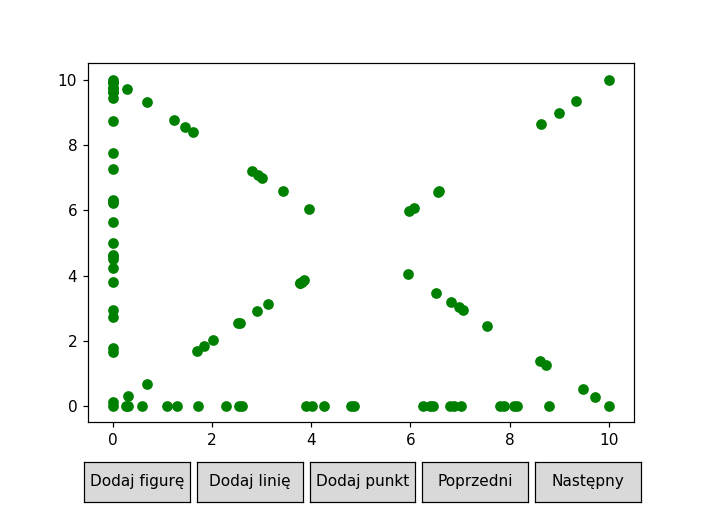

In [30]:
s,x=graham(data4)
plot=Plot(scenes = s)
plot.draw()


In [28]:
def write_graham(data):
    scenes,s=graham(data)
    with open('graham.txt', 'w') as file:
        file.write(str(s))
        file.close()

In [14]:
write_graham(data3)

In [29]:
def min_angle(a,b,c,eps):
    if a==b: return c
    if b==c: return b
    d = det3x3(a,b,c,eps)
    if d ==0:  
        if distance(a,b) > distance(a,c): return b
        else: return c
    elif d > 0: return b
    else: return c

## Jarvis

In [30]:
import time
def jarvis(data):
    eps=1e-8
    p0=min(data,key=lambda x: (x[1],x[0]))
    scenes=[]
    l=[]
    scenes.append(Scene( [ PointsCollection(data, color='green')]))
    s=[p0]
    p=p0
    while True:
        pi=p
        for pkt in data:
            if pkt!=p:
                pi=min_angle(p,pi,pkt,eps)     
        if len(s)>=1:
            l.append([s[len(s)-1],pi])
        scenes.append(Scene([ PointsCollection(data, color='green' ),
                         PointsCollection([p,pi], color='red'),
                           PointsCollection(s[:], color='blue')],
                           [LinesCollection(l[:])]))
        s.append(pi)
        p=pi
        if p==p0: break
    return scenes,s
    

In [31]:
def jarvis_time(data):
    eps=1e-8
    p0=min(data,key=lambda x: (x[1],x[0]))
    s=[p0]
    p=p0
    while True:
        pi=p
        for pkt in data:
            if pkt!=p:
                pi=min_angle(p,pi,pkt,eps)     

        p=pi
        if p==p0: break
    

In [32]:
import time

def print_time_jarvis(data):
    start1=time.time()
    jarvis_time(data)
    print("jarvis: %s ms" % ((time.time()-start1)*1000))
    

In [52]:
print_time_jarvis(data1)

jarvis: 0.9973049163818359 ms


<IPython.core.display.Javascript object>


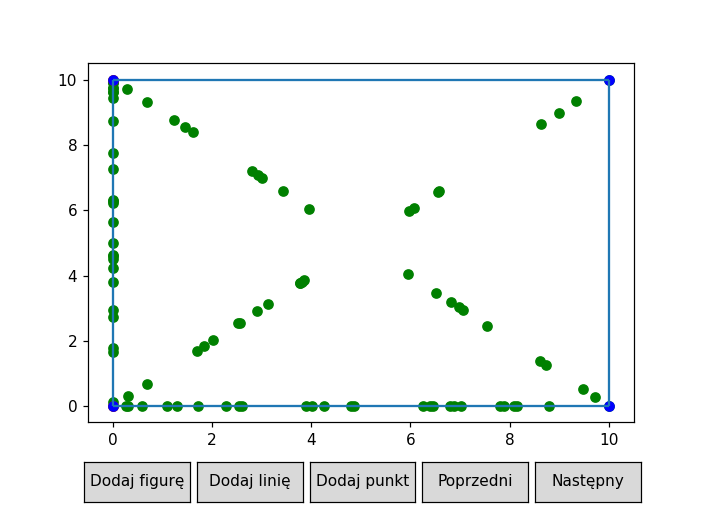

In [31]:
s,x=jarvis(data4)
plot=Plot(scenes = s)
plot.draw()
    

In [54]:
def write_jarvis(data):
    scenes,s=jarvis(data)
    with open('jarvis.txt', 'w') as file:
        file.write(str(s))
        file.close()


In [55]:
write_jarvis(data4)